# Laboratorio 2
## Miembros del equipo
- Ricardo Méndez 21289
- Sara Echeverría 21371
- Melissa Pérez 21385
- Francisco Castillo 21562

# Task 1

#### ¿Por qué el modelo de Naive Bayes se le considera “naive”?

La teoría de Bayes asume que los eventos son dependientes entre sí. Al implementarlo con un acercamiento _naive_ implica que asumimos que los eventos son independientes entre sí. Donde, básicamente, describe que una característica de un conjunto de datos no está relacionada con otra de ellas. En otras palabras, es por su simplicidad de la independencia condicional entre las características o atributos que describen los datos. [(Shoba, 2018)](https://www.sciencedirect.com/science/article/abs/pii/S0169716118300191)

#### Explique la formulación matemática que se busca optimizar en Support Vector Machine, además responda ¿cómo funciona el truco del Kernel para este modelo? 
Las máquinas de soporte vectorial buscan encontrar una frontera que maximice el margen de separation para la classification de los datos. La prediction de los datos se realiza con la siguiente fórmula:
$$
y_i = sign(w^Tx_i+b)
$$
El margen se optimiza a través de la distancia perpendicular desde la frontera hacia al punto más cercano de cada clase; es decir, maximizamos esta distancia. Esto se resuelve con multiplicadores de Lagrange (Tantos multiplicadores como cantidad de puntos tenemos)
$$
argmin_{w, ɑ} \frac{1}{2}w^Tw- \sum_{n, m=1}^{N}ɑ_mɑ_ny_my_nx_nx_m
$$
Tras resolver el problema de optimización, se obtiene la siguiente fórmula:
$$
argmax_w \sum_{n=1}^{N}ɑ_n - \frac{1}{2} \sum_{n, m=1}^{N}ɑ_nɑ_my_my_n{x_n}^Tx_m
$$
Se puede apreciar que ya no dependemos de los pesos ($w$) y el bias ($b$), sino que dependemos de los multiplicadores de Lagrange ($ɑ$). Estos multiplicadores son los que nos permiten encontrar la frontera de decision.

Las predicciones ahora se hacen de la siguiente manera:
$$
y_i = sign(\sum_{n=1}^{N}ɑ_ny_nx_n^Tx_i+b)
$$
Los datos de $x_i$ solamente aparecen como un producto punto, el cual podemos representar con una función de kernel.
$$
y_i = sign(\sum_{n=1}^{N}ɑ_ny_nK(x_n,x_i)+b)
$$

El utilizar esta function nos permite ingress el _truco del kernel_. Este truco nos permite mapear los datos a un espacio de mayor dimension, donde es más facial encontrar una frontera de decision que no es necesariamente lineal.  [(Ranjan, 2019)](https://towardsdatascience.com/truly-understanding-the-kernel-trick-1aeb11560769)

### ¿Qué tipo de ensemble learning es este modelo (Random Forest)?
Random Forest es un ensemble learning de tipo _Bootstrap Aggregation_ o _bagging_. Se utiliza para reducir la varianza de un modelo de machine learning a base de crear multiples modelos y combinarlos para obtener un modelo final. En un _Random Forest_ todos los modelos son árboles de decision. Cada arbol se entrena con diferentes subconjuntos de datos los cuales son combinados para obtener un modelo final. [(Sruthi, 2024)](https://www.analyticsvidhya.com/blog/2021/06/understanding-random-forest/)

### ¿Cuál es la idea general detrás de Random Forest?
Como se ha mencionado anteriormente, el objetivo es crear un modelo de aprendizaje que combine la salida de multiples árboles de decision para llegar a un resultado unico. 

### ¿Por qué se busca baja correlación entre los árboles de Random Forest?
Se busca que los _features_ tengan baja correlación para reducir la varianza y mejorar la precision de las predicciones. Si la correlación es alta entre estos árboles, es muy probable que cometan los mismos errores en la predicción, lo que no ofrecería ninguna mejora. [(Breiman & Cutler, s.f.)](https://www.stat.berkeley.edu/~breiman/RandomForests/cc_home.htm)

In [ ]:
import pandas as pd
import numpy as np
import string
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

scaler = StandardScaler()

# Task 2 Naive Bayes: Clasificador de Mensajes Ham/Spam

Los datos de prueba han sido obtenidos de [este enlace](https://github.com/Sk70249/NLP-Spam-Ham-Classifier/blob/master/data/SMSSpamCollection.tsv)

# Task 2.1

In [ ]:
data = []
with open('data/entrenamiento.txt', 'r') as file:
    for line in file:
        split = line.split('\t')
        if len(split) == 2:
            classification = split[0]
            message = split[1].lower()
            
            #Clean the message
            chars = ['\n', '.', ',', '!', '?', '(', ')', '"', ':', ';']
            for char in chars:
                message = message.replace(char, '')
            
            data.append([classification, message])

In [ ]:
df = pd.DataFrame(data, columns=['classification', 'message'])

In [ ]:
df.head(10)

In [ ]:
df.info()

In [ ]:
df['classification'] = df['classification'].map({'ham': 0, 'spam': 1})

In [ ]:
df.head()

In [ ]:
df['classification'].value_counts(normalize=True)

In [ ]:
# Balance the dataset
df_ham = df[df['classification'] == 0]
df_spam = df[df['classification'] == 1]
df_ham = df_ham.sample(n=len(df_spam), random_state=7)
df = pd.concat([df_ham, df_spam])

In [ ]:
df['classification'].value_counts()

In [ ]:
features = df['message']
target = df['classification']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=7)

# Task 2.2

In [ ]:
p_spam = sum(y_train == 1) / len(y_train)  # probability of spam message
p_ham = sum(y_train == 0) / len(y_train)  # probability of ham message

# Preprocess data to separate words
vocab = set()
spam_words = []
ham_words = []
vocab_size = len(vocab)

# Separate words by classification
for message, classification in zip(X_train, y_train):
    for word in message.split():
        vocab.add(word)
        if classification == 1:
            spam_words.append(word)
        else:  # ham
            ham_words.append(word)

# Laplace Smoothing for probability of word in each classification
k = 1  # Laplace smoothing constant

spam_word_probs = {word: (spam_words.count(word) + 1) / (len(spam_words) + len(vocab)) for word in vocab}
ham_word_probs = {word: (ham_words.count(word) + 1) / (len(ham_words) + len(vocab)) for word in vocab}

# Classify a new message
def classify(message):
    p_message_given_spam = np.log(p_spam)
    p_message_given_ham = np.log(p_ham)
    for word in message.split():
        if word in spam_word_probs:
            p_message_given_spam += np.log(spam_word_probs.get(word, 1 / (len(spam_words) + vocab_size * k)))
        if word in ham_word_probs:
            p_message_given_ham += np.log(ham_word_probs.get(word, 1 / (len(ham_words) + vocab_size * k)))
    return 'spam' if p_message_given_spam > p_message_given_ham else 'ham'

# Print probabilities of each classification
print(f"Probability of spam: {p_spam}")
print(f"Probability of ham: {p_ham}")

# Print probabilities of each word in each classification
print("\nSpam word probabilities:")
for word, prob in spam_word_probs.items():
    print(f"{word}: {prob}")

print("\nHam word probabilities:")
for word, prob in ham_word_probs.items():
    print(f"{word}: {prob}")

La métrica a utilizar será la precisión ya que las clases están equilibradas y ayudará a la proporción de predicciones correctas entre todas las predicciones.

In [ ]:
# Test the model on the TESTING set
y_pred = [classify(message) for message in X_test]

# Encode the predictions as 0 and 1
y_pred_encoded = [1 if prediction == 'spam' else 0 for prediction in y_pred]

# Calculate accuracy
accuracy = sum(y_pred_encoded == y_test) / len(y_test)

print(f"Accuracy on testing set: {accuracy}")

# Task 2.3

In [ ]:
# Convert the message to lowercase, remove punctuation, and remove non-ASCII characters
def clean_message(message):
    return "".join(char for char in message.lower() if char.isascii() and char not in string.punctuation)

# Asks for the input message and classifies it
Imessage = input('Introduce your message: ')
cleaned_message = clean_message(Imessage)

# Calculate the probability of the message being spam and ham
p_message_given_spam = np.log(p_spam)
p_message_given_ham = np.log(p_ham)
for word in cleaned_message.split():
    if word in spam_word_probs:
        p_message_given_spam += np.log(spam_word_probs.get(word, 1 / (len(spam_words) + vocab_size * k)))
    if word in ham_word_probs:
        p_message_given_ham += np.log(ham_word_probs.get(word, 1 / (len(ham_words) + vocab_size * k)))

print(f"Spam message probability: {np.exp(p_message_given_spam)}") 
print(f"Ham message probability: {np.exp(p_message_given_ham)}") 
print(f"\nMessage classification: {classify(cleaned_message)}") 

# Task 2.4

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score

X = df['message']
y = df['classification']

vectorizer = CountVectorizer()
X_train_counts = vectorizer.fit_transform(X_train)
X_test_counts = vectorizer.transform(X_test)

clf = MultinomialNB()
clf.fit(X_train_counts, y_train)

# Make predictions
y_test_pred = clf.predict(X_test_counts)

# Calculate accuracy
test_accuracy = accuracy_score(y_test, y_test_pred)

print(f"Accuracy on testing set: {test_accuracy}")

##### ¿Cuál implementación lo hizo mejor? ¿Su implementación o la de la librería?
Ambas implementaciones funcionaron de manera similar, aunque existen ciertas variaciones entre ellas. La implementación sin librerías tiene una ligera ventaja con los datos de prueba.

#### ¿Por qué cree que se debe esta diferencia?
Como se mencionó anteriormente, la diferencia es poca, pero se cree que la diferencia se debe a la rapidez de ejecución por lo que computacionalmente es más eficiente la implementación sin librerías.

# Task 3 Clasificación de Partidas de League of Legends

## Análisis Exploratorio

In [86]:
df_lol = pd.read_csv('data/high_diamond_ranked_10min.csv')

In [88]:
df_lol.head()

,gameId,blueWins,blueWardsPlaced,blueWardsDestroyed,blueFirstBlood,blueKills,blueDeaths,blueAssists,blueEliteMonsters,blueDragons,...,redTowersDestroyed,redTotalGold,redAvgLevel,redTotalExperience,redTotalMinionsKilled,redTotalJungleMinionsKilled,redGoldDiff,redExperienceDiff,redCSPerMin,redGoldPerMin
0,4519157822,0,28,2,1,9,6,11,0,0,...,0,16567,6.8,17047,197,55,-643,8,19.7,1656.7
1,4523371949,0,12,1,0,5,5,5,0,0,...,1,17620,6.8,17438,240,52,2908,1173,24.0,1762.0
2,4521474530,0,15,0,0,7,11,4,1,1,...,0,17285,6.8,17254,203,28,1172,1033,20.3,1728.5
3,4524384067,0,43,1,0,4,5,5,1,0,...,0,16478,7.0,17961,235,47,1321,7,23.5,1647.8
4,4436033771,0,75,4,0,6,6,6,0,0,...,0,17404,7.0,18313,225,67,1004,-230,22.5,1740.4


In [89]:
df_lol.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9879 entries, 0 to 9878
Data columns (total 40 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   gameId                        9879 non-null   int64  
 1   blueWins                      9879 non-null   int64  
 2   blueWardsPlaced               9879 non-null   int64  
 3   blueWardsDestroyed            9879 non-null   int64  
 4   blueFirstBlood                9879 non-null   int64  
 5   blueKills                     9879 non-null   int64  
 6   blueDeaths                    9879 non-null   int64  
 7   blueAssists                   9879 non-null   int64  
 8   blueEliteMonsters             9879 non-null   int64  
 9   blueDragons                   9879 non-null   int64  
 10  blueHeralds                   9879 non-null   int64  
 11  blueTowersDestroyed           9879 non-null   int64  
 12  blueTotalGold                 9879 non-null   int64  
 13  blu

In [90]:
df_lol.describe()

,gameId,blueWins,blueWardsPlaced,blueWardsDestroyed,blueFirstBlood,blueKills,blueDeaths,blueAssists,blueEliteMonsters,blueDragons,...,redTowersDestroyed,redTotalGold,redAvgLevel,redTotalExperience,redTotalMinionsKilled,redTotalJungleMinionsKilled,redGoldDiff,redExperienceDiff,redCSPerMin,redGoldPerMin
count,9.879000e+03,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000,...,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000
mean,4.500084e+09,0.499038,22.288288,2.824881,0.504808,6.183925,6.137666,6.645106,0.549954,0.361980,...,0.043021,16489.041401,6.925316,17961.730438,217.349226,51.313088,-14.414111,33.620306,21.734923,1648.904140
std,2.757328e+07,0.500024,18.019177,2.174998,0.500002,3.011028,2.933818,4.064520,0.625527,0.480597,...,0.216900,1490.888406,0.305311,1198.583912,21.911668,10.027885,2453.349179,1920.370438,2.191167,149.088841
min,4.295358e+09,0.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,11212.000000,4.800000,10465.000000,107.000000,4.000000,-11467.000000,-8348.000000,10.700000,1121.200000
25%,4.483301e+09,0.000000,14.000000,1.000000,0.000000,4.000000,4.000000,4.000000,0.000000,0.000000,...,0.000000,15427.500000,6.800000,17209.500000,203.000000,44.000000,-1596.000000,-1212.000000,20.300000,1542.750000
50%,4.510920e+09,0.000000,16.000000,3.000000,1.000000,6.000000,6.000000,6.000000,0.000000,0.000000,...,0.000000,16378.000000,7.000000,17974.000000,218.000000,51.000000,-14.000000,28.000000,21.800000,1637.800000
75%,4.521733e+09,1.000000,20.000000,4.000000,1.000000,8.000000,8.000000,9.000000,1.000000,1.000000,...,0.000000,17418.500000,7.200000,18764.500000,233.000000,57.000000,1585.500000,1290.500000,23.300000,1741.850000
max,4.527991e+09,1.000000,250.000000,27.000000,1.000000,22.000000,22.000000,29.000000,2.000000,1.000000,...,2.000000,22732.000000,8.200000,22269.000000,289.000000,92.000000,10830.000000,9333.000000,28.900000,2273.200000


In [91]:
df_lol['blueWins'].value_counts(normalize=True)

0    0.500962
1    0.499038
Name: blueWins, dtype: float64

In [92]:
features_lol = df_lol.drop(columns=['blueWins', 'gameId'])
target_lol = df_lol['blueWins']

In [93]:
# Scale everything
features_lol = pd.DataFrame(scaler.fit_transform(features_lol), columns=features_lol.columns)

In [94]:
features_lol.describe()

,blueWardsPlaced,blueWardsDestroyed,blueFirstBlood,blueKills,blueDeaths,blueAssists,blueEliteMonsters,blueDragons,blueHeralds,blueTowersDestroyed,...,redTowersDestroyed,redTotalGold,redAvgLevel,redTotalExperience,redTotalMinionsKilled,redTotalJungleMinionsKilled,redGoldDiff,redExperienceDiff,redCSPerMin,redGoldPerMin
count,9.879000e+03,9.879000e+03,9.879000e+03,9.879000e+03,9.879000e+03,9.879000e+03,9.879000e+03,9.879000e+03,9.879000e+03,9.879000e+03,...,9.879000e+03,9.879000e+03,9.879000e+03,9.879000e+03,9.879000e+03,9.879000e+03,9.879000e+03,9.879000e+03,9.879000e+03,9.879000e+03
mean,-2.876982e-17,5.034719e-18,-1.078868e-18,1.125619e-16,-1.179563e-16,-1.111234e-16,3.308530e-17,-8.702872e-17,-5.753965e-18,-2.733133e-17,...,2.589284e-17,1.146837e-15,1.444245e-15,3.394839e-16,5.897814e-16,8.055551e-17,-1.258680e-17,1.438491e-18,-1.352901e-15,-6.883180e-16
std,1.000051e+00,1.000051e+00,1.000051e+00,1.000051e+00,1.000051e+00,1.000051e+00,1.000051e+00,1.000051e+00,1.000051e+00,1.000051e+00,...,1.000051e+00,1.000051e+00,1.000051e+00,1.000051e+00,1.000051e+00,1.000051e+00,1.000051e+00,1.000051e+00,1.000051e+00,1.000051e+00
min,-9.594869e-01,-1.298863e+00,-1.009663e+00,-2.053863e+00,-2.092146e+00,-1.634988e+00,-8.792310e-01,-7.532257e-01,-4.811324e-01,-2.104390e-01,...,-1.983529e-01,-3.539707e+00,-6.961495e+00,-6.254973e+00,-5.036349e+00,-4.718391e+00,-4.668380e+00,-4.364806e+00,-5.036349e+00,-3.539707e+00
25%,-4.599937e-01,-8.390689e-01,-1.009663e+00,-7.253456e-01,-7.286663e-01,-6.508123e-01,-8.792310e-01,-7.532257e-01,-4.811324e-01,-2.104390e-01,...,-1.983529e-01,-7.120554e-01,-4.104749e-01,-6.276311e-01,-6.549000e-01,-7.293122e-01,-6.446966e-01,-6.486683e-01,-6.549000e-01,-7.120554e-01
50%,-3.489952e-01,8.051859e-02,9.904294e-01,-6.108705e-02,-4.692613e-02,-1.587244e-01,-8.792310e-01,-7.532257e-01,-4.811324e-01,-2.104390e-01,...,-1.983529e-01,-7.448379e-02,2.446271e-01,1.023723e-02,2.970140e-02,-3.122336e-02,1.688026e-04,-2.926826e-03,2.970140e-02,-7.448379e-02
75%,-1.269983e-01,5.403123e-01,9.904294e-01,6.031716e-01,6.348140e-01,5.794075e-01,7.195032e-01,1.327623e+00,-4.811324e-01,-2.104390e-01,...,-1.983529e-01,6.234576e-01,8.997291e-01,6.697989e-01,7.143028e-01,5.671385e-01,6.521677e-01,6.545317e-01,7.143028e-01,6.234576e-01
max,1.263783e+01,1.111557e+01,9.904294e-01,5.252982e+00,5.406995e+00,5.500287e+00,2.318237e+00,1.327623e+00,2.078430e+00,1.615907e+01,...,9.022956e+00,4.187620e+00,4.175239e+00,3.593814e+00,3.270148e+00,4.057583e+00,4.420473e+00,4.842738e+00,3.270148e+00,4.187620e+00


### Pasos del análisis exploratorio

#### Encoding
- No se ha realizado encoding, ya que no hay variables categóricas

#### Balanceo
- No se ha realizado balanceo, ya que el dataset está balanceado

#### Escalamiento
- Se ha realizado escalamiento de los datos, ya que las variables tienen diferentes escalas

#### Selección de Variables
- No se ha realizado selección de variables, ya que todas las variables son relevantes

In [144]:
X_train_lol, X_test_lol, y_train_lol, y_test_lol = train_test_split(features_lol, target_lol, test_size=0.2, random_state=7)

X_test_lol_10, X_tuning, y_train_lol_10, y_tuning = train_test_split(X_test_lol, y_test_lol, test_size=0.125, random_state=42)

## Task 3.1 Support Vector Machines

In [96]:
class SVM:
    def __init__(self, learning_rate=0.001, C = 0.1, n_iters=1000):
        self.lr = learning_rate
        self.C = C
        self.iter = n_iters
        self.w = None
        self.b = None

    def fit(self, X,y):
        _, n_features = X.shape

        y_ = np.where(y <= 0, -1, 1)
        self.w = np.zeros(n_features)
        self.b = 0
        fn = 0
        for feature in X:
            for idx, x_i in enumerate(X[feature]):
                condition_factor = y_[idx] * (x_i * self.w[fn] - self.b)
                condition = condition_factor >= 1
                if condition:
                    self.w -= self.lr * (2 * self.C * self.w[fn])
                else:
                    self.w[fn] -= self.lr * (2 * self.C * self.w[fn] - np.dot(x_i, y_[idx]))
                    self.b -= self.lr * y_[idx] 
            fn += 1
                    
            
                

    def predict(self, X):
        approx = np.dot(X, self.w) - self.b
        return np.sign(approx)

In [97]:
my_svm = SVM()
my_svm.fit(X_train_lol, y_train_lol)

In [98]:
from sklearn import svm

model = svm.SVC(kernel='rbf', class_weight={-1:1, 1:10})
y_training = np.where(y_train_lol.values <= 0, -1, 1)
model.fit(X_train_lol.values, y_training)

SVC(class_weight={-1: 1, 1: 10})

In [99]:

from sklearn.metrics import precision_score
predictions = my_svm.predict(X_test_lol.values)
y_pred = model.predict(X_test_lol.values)

y_true = np.where(y_test_lol.values <= 0, -1, 1)

NL_precision = precision_score(y_true, predictions, average='weighted')
L_precision = precision_score(y_true, y_pred, average='weighted')

print("Precision del modelo sin librerías: " +str(NL_precision))
print("Precisión del modelo con librerías: " + str(L_precision))

Precision del modelo sin librerías: 0.6956755777580317
Precisión del modelo con librerías: 0.7056061486082398


## Métrica de desempeño

##### Al no tener clases desbalanceadas, se decidió tomar la métrica de desempeño 'Presicion', ya que da un vistazo general del desempeño del modelo evaluando sus resultados. 

In [100]:
def hyperparam_tuning(X, y, grid):
    optimized = None
    op_score = 0
    y = np.where(y <= 0, -1, 1)

    for C in grid['C']:
        for iters in grid['iters']:
            my_model = SVM(learning_rate=0.001, C = C, n_iters=iters) 
            my_model.fit(X, y)


            y_pred = my_model.predict(X)
            score = precision_score(y,y_pred,average='weighted', zero_division=0)

            

            if score > op_score:
                op_score = score
                optimized = {'C': C, 'n_iters': iters, 'Score': op_score}
    return optimized

grid = {'C': [0.1, 1, 10, 100], 'iters': [100, 500, 1000, 2000]}

optimized_params = hyperparam_tuning(X_tuning, y_tuning, grid)
print(f'Parámetros óptimos: {optimized_params}')

Parámetros óptimos: {'C': 0.1, 'n_iters': 100, 'Score': 0.7720761723463013}


## Tunning de variables

##### Se realizó tuning al hiperparámetro C para verificar su valor. Para el modelo implementado sin librerías no se obtuvo ningún cambio, pues el valor base fue el mismo que el resultante. Por otro lado, para el modelo implementado con sklearn sí hubo un cambio, ya que su valor por defecto es de 1. Esto incrementó aproximadamente un 4% la presición del modelo. 

##### Cabe destacar que en las pruebas de la función hyperparam_tuning también se alteraba la cantidad de iteraciones. Esto puede causar overfitting, por lo que el resultado de la prueba de presición no se puede tomar como válido para el modelo en general, sino solamente como un indicio de la posible mejora del nuevo valor de C.

In [101]:
my_svm = SVM(learning_rate=0.001,C=0.1, n_iters=100)
my_svm.fit(X_train_lol, y_train_lol)

model = svm.SVC(kernel='rbf', class_weight={-1:1, 1:10}, C=0.1)
model.fit(X_train_lol.values, y_training)


predictions = my_svm.predict(X_test_lol.values)
y_pred = model.predict(X_test_lol.values)

NL_precision = precision_score(y_true, predictions, average='weighted')
L_precision = precision_score(y_true, y_pred, average='weighted')

print("Precision del modelo sin librerías: " +str(NL_precision))
print("Precisión del modelo con librerías: " + str(L_precision))

Precision del modelo sin librerías: 0.6956755777580317
Precisión del modelo con librerías: 0.7376707237750166


## El modelo, ¿ con o sin librerias ?

##### El modelo con librerías tuvo una puntuación mayor en la prueba de precisión. Esto se debe a que la implementación es más robusta debido al uso de múltiples hiper parámetros y prevenciones de overfitting junto a demás problemas.

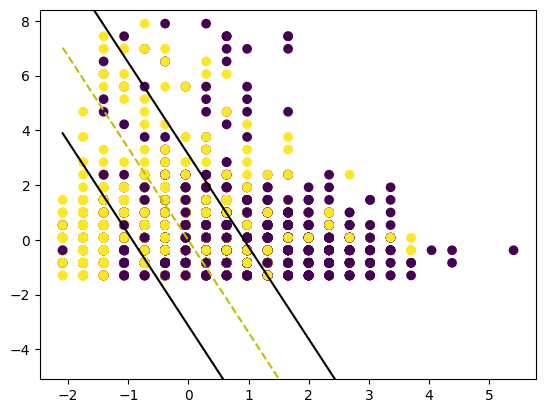

In [102]:



def svn_graph():
    def get_hyperp_val(x,w,b,offset):
        return (- w[3] * x + b + offset) / w[0]
    
    fig = plt.figure()
    ax = fig.add_subplot(1,1,1)
    plt.scatter(X_train_lol.values[:,4],X_train_lol.values[:,1], marker="o", c=y_training)

    x0_1 = np.amin(X_train_lol.values[:,4])
    x0_2 = np.amax(X_train_lol.values[:,4])

    x1_1 = get_hyperp_val(x0_1, my_svm.w, my_svm.b, 0)
    x1_2 = get_hyperp_val(x0_2, my_svm.w, my_svm.b, 0)

    x2_1 = get_hyperp_val(x0_1, my_svm.w, my_svm.b, -1)
    x2_2 = get_hyperp_val(x0_2, my_svm.w, my_svm.b, -1)

    x3_1 = get_hyperp_val(x0_1, my_svm.w, my_svm.b, 1)
    x3_2 = get_hyperp_val(x0_2, my_svm.w, my_svm.b, 1)

    ax.plot([x0_1, x0_2], [x1_1, x1_2], "y--")
    ax.plot([x0_1, x0_2], [x2_1, x2_2], "k")
    ax.plot([x0_1, x0_2], [x3_1, x3_2], "k")

    x1_min = np.amin(X_train_lol.values[:,4])
    x1_max = np.amax(X_train_lol.values[:,4])
    ax.set_ylim([x1_min -3, x1_max +3])
    plt.show()

svn_graph()

#### En la gráfica se puede ver que las dos mayores concentraciones en los dos grupos son aquellas separadas por el hiperplano. Como los puntos se encuentran muy dispersos y muy juntos a la vez, es muy difícil para el modelo poder separarlos efectivamente.

## Task 3.2 Árboles de Decisión

### Sin librerías

In [155]:
class Node:
    def __init__(self, feature, threshold, left, right):
        self.feature = feature
        self.threshold = threshold
        self.left = left
        self.right = right

    # predict the class label
    def predict(self, sample):
        if sample[self.feature] < self.threshold:
            return self.left.predict(sample) if isinstance(self.left, Node) else self.left # if left is a node, call predict again, else return the value
        else:
            return self.right.predict(sample) if isinstance(self.right, Node) else self.right # if right is a node, call predict again, else return the value

# main function to build the tree
def build_tree(X, y, depth=0, max_depth=5):
    if depth >= max_depth or len(set(y)) == 1: # base case
        return Counter(y).most_common(1)[0][0] # most common class label
    else:
        num_features = X.shape[1] # number of columns
        best_feature, best_threshold, best_gini = None, None, float('inf')
        for feature in range(num_features):
            thresholds = set(X[:, feature])
            for threshold in thresholds:
                y_left = y[X[:, feature] < threshold]
                y_right = y[X[:, feature] >= threshold]
                gini = (len(y_left) * gini_impurity(y_left) + len(y_right) * gini_impurity(y_right)) / len(y) # weighted average
                if gini < best_gini:
                    best_feature, best_threshold, best_gini = feature, threshold, gini
        left_idxs = X[:, best_feature] < best_threshold
        right_idxs = X[:, best_feature] >= best_threshold
        left = build_tree(X[left_idxs], y[left_idxs], depth + 1, max_depth)
        right = build_tree(X[right_idxs], y[right_idxs], depth + 1, max_depth)
        return Node(best_feature, best_threshold, left, right)

# calculate the gini impurity
tree = build_tree(X_train_lol.values, y_train_lol.values)
predictions = [tree.predict(sample) for sample in X_test_lol.values]


C:\Users\sarap\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\sarap\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [156]:
def accuracy(y_true, y_pred):
    mask = np.where(y_true == y_pred, 1, 0)
    return np.mean(mask)

# predictions to int
predictions = np.array([tree.predict(sample) for sample in X_test_lol.values]) 
y_pred = np.array([int(p) for p in predictions])
y_true = y_test_lol.values
acc = accuracy(y_true, y_pred)
print(f"Accuracy: {acc:.4f}")

Accuracy: 0.4954


(Dhiraj, 2021)

### Con librerías

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score

In [ ]:
# initialize the model & training
dt_model = DecisionTreeClassifier(random_state=7)
dt_model.fit(X_train_lol, y_train_lol)

In [ ]:
# predictions on the testing data
y_pred_lol = dt_model.predict(X_test_lol)

In [ ]:
# initialize the Decision Tree model with limited depth and minimum samples for splitting
dt_model = DecisionTreeClassifier(max_depth=5, min_samples_split=5, random_state=7)

In [ ]:
# model evaluation
print("Accuracy:", accuracy_score(y_test_lol, y_pred_lol))

In [ ]:
# cross-validation implementation to evaluate the model
cv_scores = cross_val_score(dt_model, features_lol, target_lol, cv=5)
print("Accuracy using cv:", cv_scores.mean())

(Baheti, 2023)

## Task 3.3 Comparación

# Referencias

- Baheti. (2023). What is Overfitting in Deep Learning [+10 Ways to Avoid It]. V7. https://www.v7labs.com/blog/overfitting#:~:text=Cross-validation%20is%20a%20robust,fold%20as%20the%20test%20set.
- Dhiraj. (2021). Decision Tree Machine Learning Algorithm from Scratch in Python. Medium. https://dhirajkumarblog.medium.com/decision-tree-from-scratch-in-python-629631ec3e3a